In [1]:
#################################
#Run this cell if using Google COLAB
#################################

#clone the repository and the data to run the notebook on Google Colab
!git clone https://github.com/GiancarloCroce/DCA_SARS-CoV-2
%cd ./DCA_SARS-CoV-2
#for plotly on google colab
import plotly.io as pio
pio.renderers.default = 'colab'

Cloning into 'DCA_SARS-CoV-2'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 115 (delta 37), reused 106 (delta 28), pack-reused 0
Receiving objects: 100% (115/115), 6.27 MiB | 3.17 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/home/giancarlo/Documents/lab_work/martin_project_CoVid-19/DCA_SARS-CoV-2/DCA_SARS-CoV-2


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pandas as pd
import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go  
from sklearn import metrics
from utils import load_data_dca, plot_roc, plot_dca_IEDB, plot_dca_IEDB_BTcell
from utils import get_IEDB_versions, compute_RF, get_updated_IEDB


# DCA for SARS-CoV-2

We assign a [Direct Coupling Analysis](https://en.wikipedia.org/wiki/Direct_coupling_analysis) mutability score to each position of the SARS-CoV-2 proteome contained in a PFAM domain (see Section **Data** at the end of the notebook).
Column in the dataframe: **mutability_score(DCA)**.

Similarly, we compute the mutability scores using conservation profiles (hereinafter independent models - IND).
Column in the dataframe: **mutability_score(IND)**.

Both the IND and the DCA model are unsupervised models (no SARS-CoV-2 data in the training set), trained on multiple sequence alignments sequence alignments (MSA) of SARS-CoV-2 related coronaviruses.

We consider as reference the aa_Wuhan-Hu-1 strain (Accession [NC045512](https://www.genome.jp/dbget-bin/www_bget?refseq:NC_045512)). Sites with high mutability scores are expected to have already mutated or to mutate in the future. Our predictions are validated with the mutations observed in SARS-CoV-2 proteomes deposited in the GISAID [https://www.gisaid.org/] database.

We consider 3 different time periods for the GISAID data:
1.  January 2020 to July 2020 (Column: **observed_mut_Jul2020**)
2.  January 2020 to December 2020 (Column: **observed_mut_Dec2020**)
3.  January 2020 to May 2021 (Column: **observed_mut_May2021**)


## Receptor Binding Domain

Here we restrict our analysis to the Receptor Binding Domain (```dom = "bCoV_S1_RBD"```) of the SARS-CoV-2 Spike protein (```prot = "Spike" ```).

In [2]:
# Load data (for a specific protein and domain)
prot = "Spike"
dom = "bCoV_S1_RBD"

df = load_data_dca(path_data = "./data/data_dca_proteome.csv", protein = prot, domain = dom)

#sort by DCA-mutability score to identify putative mutable sites 
df = df.sort_values(by ="mutability_score(DCA)", ascending = False)
print(df)

     protein       domain  position_protein  position_domain aa_Wuhan-Hu-1  \
7618   Spike  bCoV_S1_RBD               519            171.0             H   
7502   Spike  bCoV_S1_RBD               403             55.0             R   
7589   Spike  bCoV_S1_RBD               490            142.0             F   
7592   Spike  bCoV_S1_RBD               493            145.0             Q   
7471   Spike  bCoV_S1_RBD               372             24.0             A   
...      ...          ...               ...              ...           ...   
7490   Spike  bCoV_S1_RBD               391             43.0             C   
7522   Spike  bCoV_S1_RBD               423             75.0             Y   
7531   Spike  bCoV_S1_RBD               432             84.0             C   
7521   Spike  bCoV_S1_RBD               422             74.0             N   
7478   Spike  bCoV_S1_RBD               379             31.0             C   

      mutability_score(IND)  mutability_score(DCA)  observed_mu

## 1. Predicting mutable sites

In Fig. 2 of the paper we use the DCA and IND model to identify mutations already present in circulating strains.

We consider as:
- **mutable** (1):  a site with **N_mut or more** observed mutations in GISAID strains
- **constrained** (0): a site with **less than N_mut**  observed mutations in GISAID strains

Here we fix N_mut=16 and include GIDAS data from January 2020 to May 2021.


******************************************************
   GISAID data from Jan 2020 to observed_mut_May2021
******************************************************
113 sites are constrained (tp = 0)
     constrained if < 16 mutations in GISAID
65 sites are mutable (tp = 1)
     mutable if >= 16 mutations in GISAID


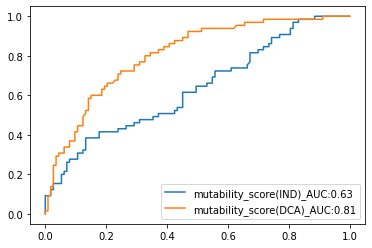

In [3]:
## ROC DCA vs. IND model, FIG.2

# define constrained and mutable sites
N_mut = 16
constrained = range(0,N_mut)
mutable = range(N_mut,1000000) #1000000 a random big number 

# GISAID data 
GISAID = 'observed_mut_May2021'

list_score = ['mutability_score(IND)', 'mutability_score(DCA)']
plot_roc(constrained, mutable, GISAID, list_score, df)


### print some info
num_contrained = np.sum(df[GISAID].isin(constrained))
num_mutable = np.sum(df[GISAID].isin(mutable))

print("******************************************************")
print("   GISAID data from Jan 2020 to {0}".format(GISAID))
print("******************************************************")
print("{0} sites are constrained (tp = 0)".format(num_contrained))
print('     constrained if < '+str(N_mut) + ' mutations in GISAID')
print("{0} sites are mutable (tp = 1)".format(num_mutable))
print('     mutable if >= '+str(N_mut) + ' mutations in GISAID')

### Mutations are accumulating

Here we access the predictive power of the DCA mutability scores considering  3 timepoints (July 2020, December 2020, May 2020) for the GISAID data.
We observe an increasing agreement between our model and the observed variability as more data become available over time.

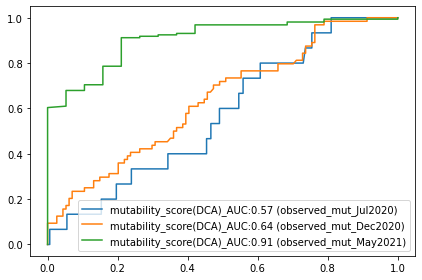

In [4]:
## ROC DCA, GISAID at different time,  FIG.2

# define constrained and mutable sites
N_mut = 4
constrained = range(0,N_mut)
mutable = range(N_mut,1000000) #1000000: a random big number
list_score = ['mutability_score(DCA)']
              
observed_mutability = 'observed_mut_Jul2020'
plot_roc(constrained, mutable, observed_mutability, list_score, df, add_obs_mut = True)
observed_mutability = 'observed_mut_Dec2020'
plot_roc(constrained, mutable, observed_mutability, list_score, df, add_obs_mut = True)
observed_mutability = 'observed_mut_May2021'
plot_roc(constrained, mutable, observed_mutability, list_score, df, add_obs_mut = True)
plt.tight_layout()

## 2. Predicting immunologically relevant mutable sites

Nonsynonymous mutations may modify regions of the SARS-CoV-2 genome targeted by B or T cells (known as B/T cell epitopes). 

The [IEDB](https://www.iedb.org/) collects experimentally validated B and T cell epitopes.
Each SARS-CoV-2 sites is associated with the corresponding epitope response frequency (RF), defined as the number of positively responded subjects, averaged over all epitopes mapped to that position. See  https://help.iedb.org/hc/en-us/articles/114094147751 for more details.

Amino acid substitution at high-RF sites have a higher risk of inducing immune escape as many positively responding epitopes are modified. 

### DCA and IEDB (paper results)
Here we plot the DCA mutability score vs. the IEDB response frequency for each site of the RDB domain (Fig 3B).

The interesting region is the **upper right corner** containing sites which are expected to be mutable (high DCA score) and that can induce immune escape (high RF).

In the paper we use:
- IDEB epitope data of 16 May 2021. 
- May 18th, 2021 the WHO weekly epidemiological report on Covid-19 (https://www.who.int/publications/m/item/weekly-epidemiological-update-on-covid-19---18-may-2021) the define Variants of Concern (VOC) or Variants of Interest (VOI). They have mutations in the 417, 452, 477, 478, 483, 484 and 501 positions of the RBD domain (red points in the plot).

See the next cell for updated IEDB and WHO data. 

In [40]:
# DCA vs. IEDB response frequency
prot = "Spike"
dom = "bCoV_S1_RBD"
score = 'mutability_score(DCA)'

#positions mutated in VOI/VOC
list_pos_mutated_VOI_VOC = [417, 452, 477, 478, 483, 484,  501] #red points

df = load_data_dca(path_data = "./data/data_dca_iedb_RDB_domain.csv", protein = prot, domain = dom)
#print(df)
plot_dca_IEDB(df, score, list_pos = list_pos_mutated_VOI_VOC)

### To plot only B(T) cell epitopes (Fig S5)
#df = load_data_dca(path_data = "./data/data_dca_iedb_RDB_domain_BTcell.csv", protein = prot, domain = dom)
#BT_cell = "B_cell" #"T_cell"
#print('***** {0} epitopes *****'.format(BT_cell))
#plot_dca_IEDB_BTcell(df, score, list_pos = list_pos_mutated_VOI_VOC, cell_type = BT_cell)

0

### DCA and IEDB (UPDATED results)
We repeat the same analysis with updated IEDB epitope data and WHO defitions of VOIs/VOCs. 

Check the WHO (https://www.who.int/en/activities/tracking-SARS-CoV-2-variants) or the CoVariants(https://covariants.org/shared-mutations) dedicated website to identify RDB mutations in Variants of Interest (VOIs) or Variants of Concern (VOCs).

In [42]:
prot = "Spike"
dom = "bCoV_S1_RBD"
df = load_data_dca(path_data = "./data/data_dca_proteome.csv", protein = prot, domain = dom)

#get IEDB available versions:
list_IEDB_versions =  get_IEDB_versions()
IEDB_ver = '04Jul2021'
#IEDB_ver = '16May2021'
#IEDB_ver = '30Apr2021'
df = get_updated_IEDB(df, IEDB_ver)

#RDB positions mutated in VOIs/VOCs
list_pos_mutated_RBD = [417, 452, 477, 478, 484, 490, 494, 501] 
score = 'mutability_score(DCA)'
plot_dca_IEDB(df, score, list_pos = list_pos_mutated_RBD)

IEDB available versions: ['30Apr2021', '16May2021', '04Jul2021']
Selecting *** IEDB 04Jul2021 version ***


0

## 3. Data
DCA predictions are available for the following proteins and protein domains, with
 - **M_eff**= the effective number of sequences used for the DCA model
 - **L** = the length of the PFAM domain


In [13]:
data_prot_domain = pd.read_csv("./data/data_meff.csv")
data_prot_domain

,Protein/ORF,Pfam_identifier,Pfam_accession,M_eff,L
0,Envelope,CoV_E,PF02723.15,53,66
1,Membrane,CoV_M,PF01635.19,38,201
2,Nucleocapsid,CoV_nucleocap,PF00937.19,48,341
3,ORF1a,bCoV_NAR,PF16251.6,19,98
4,ORF1a,bCoV_NSP1,PF11501.9,12,135
5,ORF1a,bCoV_NSP3_N,PF12379.9,9,171
6,ORF1a,bCoV_SUD_C,PF12124.9,2,64
7,ORF1a,bCoV_SUD_M,PF11633.9,10,143
8,ORF1a,CoV_NSP10,PF09401.11,25,123
9,ORF1a,CoV_NSP2_C,PF19212.1,22,167
